# Пример использования библиотеки BigARTM для тематического моделирования
## Для Bigartm v0.8.0
### Редактировал Максим Чурилин

Импортируем BigARTM:

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

In [23]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [24]:
import os
os.environ["ARTM_SHARED_LIBRARY"] = "/Users/adrianoff/dev/BigARTM/build/lib/libartm.dylib"
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", 
                                       target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [25]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [55]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text": 1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)
# число после названия модальностей - это их веса

Создаем словарь и инициализируем модель с его помощью

In [56]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [57]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

In [58]:
model_artm.initialize('dictionary')

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [59]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

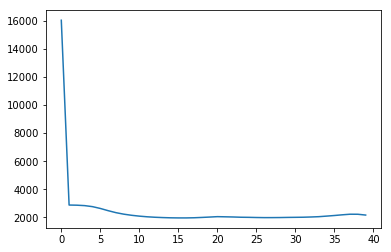

In [60]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [76]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0: 

KeyError: 'top_words'

Давайте посмотрим также на разреженность матриц:

In [62]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.733318839679
0.165336134454


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [63]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=dictionary))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [64]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [65]:
model_artm.topic_names
tokens = model_artm.score_tracker["top_words"].last_tokens
#print tokens

for key in tokens:
   print "key: %s , value: %s" % (key, tokens[key])

# for topic_name in model_artm.topic_names:
#     print topic_name + ': ',
#     tokens = model_artm.score_tracker["top_words"].last_tokens
#     for word in tokens[topic_name]:    
#         print word,
#     print

key: sbj5 , value: [u'\u0431\u044b\u0442\u044c', u'\u0444\u0443\u043d\u043a\u0446\u0438\u044f', u'\u043f\u0443\u0448\u043a\u0438\u043d', u'\u0442\u043e\u0447\u043a\u0430', u'\u0442\u0440\u0435\u043d\u0438\u0435', u'a', u'\u0433\u043e\u0434', u'f', u'\u043f\u0440\u0435\u0434\u043b\u043e\u0436\u0435\u043d\u0438\u0435', u'\u0438\u043c\u043f\u0435\u0440\u0438\u044f', u'\u043e\u0431\u043b\u0430\u0441\u0442\u044c', u'\u0437\u0432\u0443\u043a', u'\u0441\u0443\u0449\u0435\u0441\u0442\u0432\u0438\u0442\u0435\u043b\u044c\u043d\u043e\u0435', u'\u044f\u0437\u044b\u043a', u'\u043f\u0440\u0438\u043c\u0435\u0440']
key: sbj4 , value: [u'x', u'a', u'b', u'\u0447\u0438\u0441\u043b\u043e', u'\u0443\u0440\u0430\u0432\u043d\u0435\u043d\u0438\u0435', u'\u043a\u043e\u0440\u0435\u043d\u044c', u'\u0434\u0440\u043e\u0431\u044c', u'\u0444\u0443\u043d\u043a\u0446\u0438\u044f', u'y', u'\u043a\u0432\u0430\u0434\u0440\u0430\u0442\u043d\u044b\u0439', u'\u0441\u0442\u0435\u043f\u0435\u043d\u044c', u'f', u'\u0440\u0435

In [66]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.816808497422
0.302521008403


Попробуем менять коэффициент регуляризации:

In [67]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [68]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [69]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  предложение вода корень древний квадратный дом n океан жить собственный крестьянин член александр зона достигать
sbj1: 

KeyError: u'sbj1'

In [70]:
# еще раз посмотрим на разреженность
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

 0.910509969563
0.48487394958


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [71]:
model_artm.save("my_model")

In [72]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [73]:
phi = model_artm.get_phi()

In [74]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
подвелась,0.000000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000
фигурка,0.000000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000
бизон,0.000000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000
мамонт,0.000000,0.0,0.0,0.000000,0.0,0.000275,0.0,0.000000,0.000000,0.000000
усопший,0.000000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000
палеолит,0.000000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000
Sapiens,0.000000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000
Homo,0.000000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000
цельсий,0.000000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000
условияКлимат,0.000000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000


Матрица вероятностей тем в документах.

In [75]:
theta = model_artm.get_theta()
theta

,200,201,202,203,204,205,206,207,208,209,...,390,391,392,393,394,395,396,397,398,399
sbj0,0.032051,0.052632,0.093117,0.025000,0.011765,0.008811,0.042169,0.0300,0.047751,0.072848,...,0.301038,0.217631,0.335009,0.438202,0.448997,0.545729,0.381868,0.198473,0.234286,0.477607
sbj1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj3,0.009615,0.000000,0.000000,0.066667,0.000000,0.000000,0.021084,0.0175,0.185856,0.016556,...,0.006920,0.024793,0.037288,0.011236,0.024465,0.013863,0.030220,0.041985,0.000000,0.099707
sbj4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.027682,0.008264,0.017534,0.028090,0.015291,0.072761,0.005495,0.057252,0.051429,0.049853
sbj6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.003460,0.011019,0.027119,0.028090,0.015291,0.011765,0.000000,0.015267,0.011429,0.011730
sbj8,0.080128,0.473684,0.275304,0.054167,0.290196,0.202643,0.045181,0.0325,0.090164,0.069536,...,0.076125,0.088154,0.115254,0.050562,0.055591,0.032353,0.101648,0.091603,0.222857,0.070780
sbj9,0.878205,0.473684,0.631579,0.854167,0.698039,0.788546,0.891566,0.9200,0.676230,0.841060,...,0.584775,0.650138,0.467796,0.443820,0.440367,0.323529,0.480769,0.595420,0.480000,0.290322


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [28]:
theta_test = model_artm.transform(batch_vectorizer)